# Car Price Prediction

## Description

We are going to be using a dataset that contains certain information of cars.

The main aim of the study is going to be predicting the price of a car whose certain features are given.

Linear regression and its derivatives, namely Lasso and Ridge are going to be used as the relevant models.

Then we will do cross validation and scoring to evaluate and compare the models.

# Importing Necessary Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

# Reading the Dataset

In [2]:
raw_data = pd.read_csv('train.csv')

In [4]:
raw_data.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [5]:
raw_data = raw_data.drop(['v.id','on road old','on road now','condition', 'economy'], axis = 1)

In [6]:
raw_data

,years,km,rating,top speed,hp,torque,current price
0,3,78945,1,177,73,123,351318.0
1,6,117220,5,148,74,95,285001.5
2,2,132538,2,181,53,97,215386.0
3,4,101065,4,197,54,116,244295.5
4,6,61559,3,160,53,105,531114.5
...,...,...,...,...,...,...,...
995,5,125092,1,171,95,97,190744.0
996,4,83370,2,161,101,120,419748.0
997,7,86722,1,196,113,89,405871.0
998,2,140478,4,184,112,128,74398.0


# EDA of the Dataset

In [7]:
raw_data.describe(include = 'all')

,years,km,rating,top speed,hp,torque,current price
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.00000
mean,4.561000,100274.430000,2.988000,166.89300,84.54600,103.423000,308520.24250
std,1.719079,29150.463233,1.402791,19.28838,20.51694,21.058716,126073.25915
min,2.000000,50324.000000,1.000000,135.00000,50.00000,68.000000,28226.50000
25%,3.000000,74367.500000,2.000000,150.00000,67.00000,85.000000,206871.75000
50%,5.000000,100139.500000,3.000000,166.00000,84.00000,104.000000,306717.75000
75%,6.000000,125048.000000,4.000000,184.00000,102.00000,121.000000,414260.87500
max,7.000000,149902.000000,5.000000,200.00000,120.00000,140.000000,584267.50000


In [8]:
raw_data.isnull().sum()

years            0
km               0
rating           0
top speed        0
hp               0
torque           0
current price    0
dtype: int64

From the above, we see that we have 1000 rows and initially 12 columns. We do not have missing values (an indication that the dataset was most probably already preprocessed, however we will certainly continue to check the OLS assumptions).

In order to have a better explanation of the target, I believe I need to remove some of the features. This is because in the description of the features, I believe the 7 columns that I have left above will serve the purpose better. 

Now let's check the OLS assumptions such as the distribution of features and target for a better 

<AxesSubplot:xlabel='current price', ylabel='Count'>

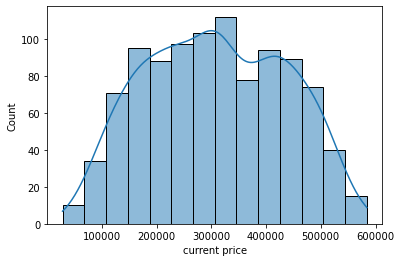

In [9]:
sns.histplot(raw_data['current price'], kde = True)

<AxesSubplot:xlabel='torque', ylabel='Count'>

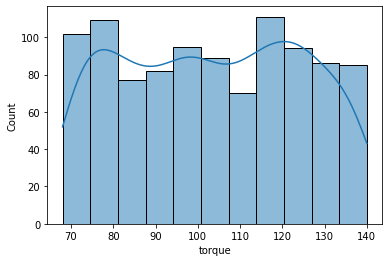

In [10]:
sns.histplot(raw_data['torque'], kde = True)

<AxesSubplot:xlabel='hp', ylabel='Count'>

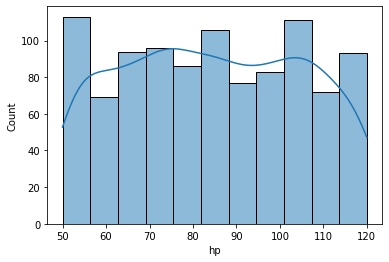

In [11]:
sns.histplot(raw_data['hp'], kde = True)

<AxesSubplot:xlabel='top speed', ylabel='Count'>

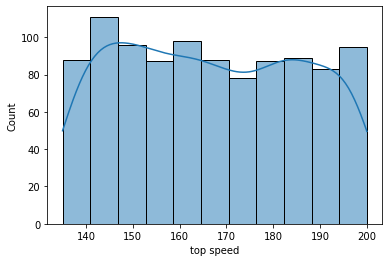

In [12]:
sns.histplot(raw_data['top speed'], kde = True)

<AxesSubplot:xlabel='years', ylabel='Count'>

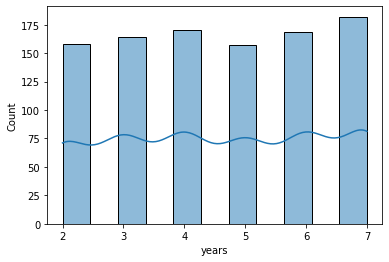

In [13]:
sns.histplot(raw_data['years'], kde = True)

### Checking Linearity

Text(0.5, 1.0, 'Torque and Current Price')

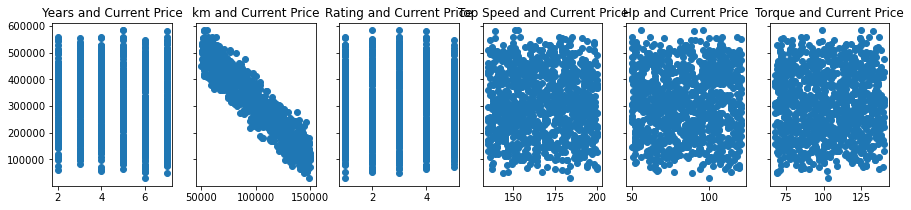

In [18]:
f, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,sharey = True, figsize = (15,3))
ax1.scatter(raw_data['years'], raw_data['current price'])
ax1.set_title('Years and Current Price')
ax2.scatter(raw_data['km'], raw_data['current price'])
ax2.set_title('km and Current Price')
ax3.scatter(raw_data['rating'], raw_data['current price'])
ax3.set_title('Rating and Current Price')
ax4.scatter(raw_data['top speed'], raw_data['current price'])
ax4.set_title('Top Speed and Current Price')
ax5.scatter(raw_data['hp'], raw_data['current price'])
ax5.set_title('Hp and Current Price')
ax6.scatter(raw_data['torque'], raw_data['current price'])
ax6.set_title('Torque and Current Price')

### Checking Multicolliniarity

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables  = raw_data[['years', 'km', 'rating', 'top speed', 'hp', 'torque']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i ) for i in range(variables.shape[1])]
vif['features'] = variables.columns

In [20]:
vif

,VIF,features
0,7.773160,years
1,11.803183,km
2,5.290393,rating
3,37.065590,top speed
4,16.101149,hp
5,20.637532,torque


In order to get away with the multicolliniarity, I am dropping the ones with high VIF score.

In [21]:
data_no_multicolliniearity = raw_data.drop(['top speed', 'torque'], axis = 1)

In [22]:
data_no_multicolliniearity.describe(include = 'all')

,years,km,rating,hp,current price
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000
mean,4.561000,100274.430000,2.988000,84.54600,308520.24250
std,1.719079,29150.463233,1.402791,20.51694,126073.25915
min,2.000000,50324.000000,1.000000,50.00000,28226.50000
25%,3.000000,74367.500000,2.000000,67.00000,206871.75000
50%,5.000000,100139.500000,3.000000,84.00000,306717.75000
75%,6.000000,125048.000000,4.000000,102.00000,414260.87500
max,7.000000,149902.000000,5.000000,120.00000,584267.50000


In [23]:
data_preprocessed = data_no_multicolliniearity

# The Models and Their Comparison

In [25]:
X = data_preprocessed.drop('current price', axis=1)
y = data_preprocessed['current price']

In [26]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [27]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 2  3  5  6  7  8 10 11 12 13] 666
Test index: [ 0  1  4  9 16 17 23 26 30 32] 334

Train index: [ 0  1  3  4  5  7  8  9 10 11] 667
Test index: [ 2  6 12 15 19 21 24 25 27 29] 333

Train index: [ 0  1  2  4  6  9 12 15 16 17] 667
Test index: [ 3  5  7  8 10 11 13 14 18 20] 333



#### Linear Regression

In [30]:
scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.8688140888900903, 0.8869001329541193, 0.868442277601345]

In a Linear Regression our scores did not really differ, but we will continue to try Lasso and Ridge.

#### Ridge and Lasso

In [31]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

In [35]:
s = StandardScaler()

scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

C:\Users\pc1\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3604778374.2856445, tolerance: 1052681795.1783217
  model = cd_fast.enet_coordinate_descent(


In [36]:
list(zip(alphas,scores))

[(1e-09, 0.8749885692626127),
 (1e-08, 0.8749885692626151),
 (1e-07, 0.8749885692626405),
 (1e-06, 0.8749885692628933),
 (1e-05, 0.8749885692655153),
 (0.0001, 0.8749885692908066),
 (0.001, 0.8749885695540321),
 (0.01, 0.8749885717195537),
 (0.1, 0.8749885970174512),
 (1.0, 0.8749888542321753)]

In [37]:
Lasso(alpha=1e-6).fit(X, y).coef_

C:\Users\pc1\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154791957891.03027, tolerance: 1587857220.5989442
  model = cd_fast.enet_coordinate_descent(


array([-1012.71929667,    -4.05279054,  -219.60550001,  -119.52270638])

In [38]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-1012.39153292,    -4.05278941,  -219.10574124,  -119.51938088])

# Conlcusion

First of all, the dataset was already quite well preprocessed, so it certainly had an effect on our model.

As can be seen, we have better scores from Ridge and Lasso in comparison to Linear Regression. This is because Lasso and Ridge have better regularization and more detailed hyperparameter tuning. 

In order to get even better scores:
1- We can change the folds,
2- We can use stratified kfolds or group folds to change the nature of folding,
3- Here, changing alpha parameter does not really change anything that much, since the scores are very close to one another, most probably because of the extremely well normally distributed dataset.

END